### ULDM with pyHalo

This notebook demonstrates how pyHalo creates ultra-light dark matter (ULDM) halos and how to generate realizations of ULDM halos. 

lenstronomy is required to run some of the code in this notebook. You can download lenstronomy with the following command: 

$\texttt{pip install lenstronomy --user}$

In [1]:
from pyHalo.preset_models import ULDM
from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.single_realization import SingleHalo

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from lenstronomy.LensModel.Profiles.cnfw import CNFW
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.LensModel.Profiles.uldm import Uldm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

pyHalo constructs ULDM halos by superimposing a ULDM density profile and a cored NFW density profile. ULDM halos are defined by their halo (virial) mass $M_{h},$ the assumed ultra-light axion mass $m_{\psi}.$ These inputs determine the soliton core size $r_c$ and density $\rho_c$ which are expected to form in ULDM halos. For details, see $\href{https://arxiv.org/pdf/1407.7762.pdf}{\text{Schive et al. 2014b}}.$ 

Given $M_h$ and $m_{\psi}$ pyHalo uses an optimization algorithm to tune the cored radius $r_{core}$ (of the NFW component) and the central density (of the composite profile: CNFW + ULDM) such that the resulting profile has the desired $M_h,$ while preserving the ULDM core density. The result is a composite density profile which has a soliton core at small radii and which transitions to a NFW profile at large radii.

In [2]:
# pyHalo inputs to generate single ULDM halos

mass = 1e10 # halo mass in solar masses
profile_args = [{'log10_m_uldm': log10_m_uldm,
                 'uldm_plaw': 1/3,
                 'scale_nfw':False,
                 'evaluate_mc_at_zlens':True,
                 'c_scatter':False} for log10_m_uldm in [-22,-21.5,-21]] # a few axion masses

# Don't worry about the 'uldm_plaw' parameter, you will not have to specify it when creating ULDM realizations
# The 'scale_nfw' parameter specifies whether or not to rescale alpha_Rs (improves mass accuracy)
# 'evaluate_mc_at_z_lens' & 'c_scatter' ensure concentration-mass relations are the same for all halos

z_lens,z_source = 0.5,1.5
x,y = 0.,0.
r3d = np.sqrt(1 + 0.5 ** 2 + 70**2)
sub_flag = True
lc = LensCosmo(z_lens=z_lens,z_source=z_source)

In [3]:
# Generate 3 ULDM halos with the above mass, each with a different axion mass
# Lensing quantities are then computed for each halo

single_halos = [SingleHalo(mass,x,y,'ULDM',z_lens,z_lens,z_source,lc,sub_flag,profile_arg,None)
                for profile_arg in profile_args]

kwargs_lens = [single_halo.lensing_quantities(add_mass_sheet_correction=False)[2]
              for single_halo in single_halos]

In [4]:
# Function which, given radii and lensing quantities, returns the density profile of the ULDM halo
# as well as the individual components (CNFW, ULDM)

def lens_to_rho(r,lp):
    cnfw, uldm = lp
    alpha_Rs, Rs, r_core = cnfw['alpha_Rs'], cnfw['Rs'], cnfw['r_core']
    kappa_0, theta_c = uldm['kappa_0'], uldm['theta_c']
    sigmacrit = lc.sigma_crit_lens_kpc
    rc = theta_c * lc.cosmo.kpc_proper_per_asec(z_lens)
    rhoc = sigmacrit * 2048 * np.sqrt(0.091) * kappa_0 / (429 * np.pi * rc)
    rho_cnfw = CNFW().density_lens(r,Rs,alpha_Rs,r_core)*sigmacrit*(lc.D_d*1e3)*lc.cosmo.arcsec
    rho_uldm = Uldm().density(r,rhoc,theta_c)
    return rho_cnfw + rho_uldm, rho_cnfw, rho_uldm

In [5]:
r_arr = np.logspace(-2,1,1000) # units of Rs_angle (for an NFW profile with an equivalent mass)
args = (mass, single_halos[0].halos[0].c, single_halos[0].halos[0].z)
Rs_nfw,alpha_Rs_nfw = lc.nfw_physical2angle(*args)
r = Rs_nfw * r_arr

rhos = [lens_to_rho(r,lp) for lp in kwargs_lens]

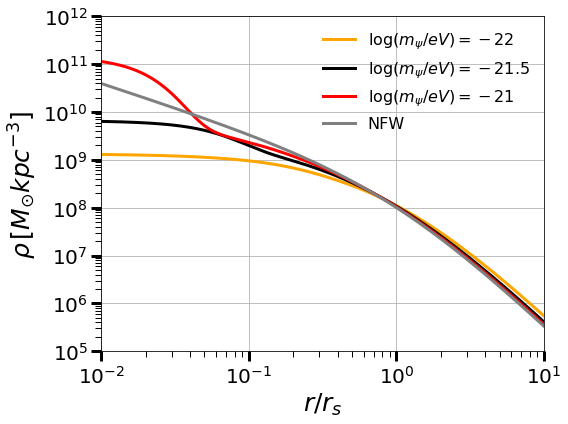

In [6]:
# Plot the density profiles

cs = ['orange','black','red']
labels = [r'$\log(m_{\psi}/eV)=%s$' % parg['log10_m_uldm'] for parg in profile_args]
fig=plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.rcParams['axes.linewidth'] = 3
for i,rho in enumerate(rhos):
    ax.loglog(r_arr,rho[0],cs[i],linewidth=3,label=labels[i])
ax.loglog(r_arr,NFW().density_lens(r,Rs_nfw,alpha_Rs_nfw)*lc.sigma_crit_lens_kpc*lc.cosmo.arcsec*(lc.D_d*1e3),
          linewidth=3,color='gray',label='NFW')
ax.set_xlabel(r'$r/r_s$',fontsize=25)
ax.set_ylabel(r'$\rho\,[M_{\odot}kpc^{-3}]$',fontsize=25)
ax.minorticks_on()
ys = np.logspace(5,12,8)
y_major = ax.set_yticks(ys)
ax.tick_params(which='major', length=10, width=2, direction='out',labelsize=20)
ax.tick_params(which='minor', length=6, width=1, direction='out')
ax.set_xlim(r_arr[0],r_arr[-1])
ax.set_ylim(ys[0],ys[-1])
ax.legend(fontsize=16,frameon=False)
ax.tick_params(width=3,length=10)
ax.grid()
plt.tight_layout()
plt.show()

As the ultra-light axion mass decreases, the quantum pressure between axions within the halo cores will increase. This causes an increase in the core size, which you can observe in the above figure showing ULDM density profiles for varying axion mass. An NFW profile with the same halo mass is also plotted to demonstrate that the ULDM profiles transition to an NFW profile at large radii.

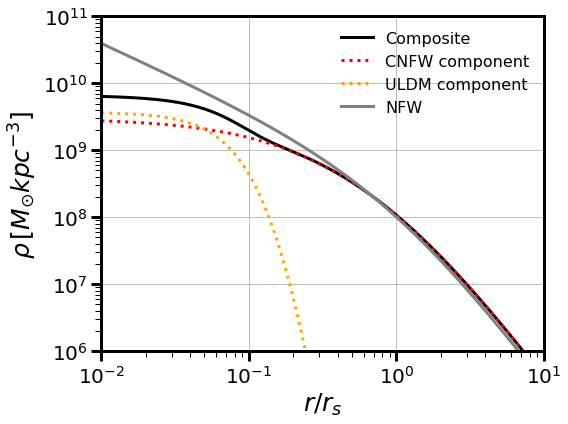

In [7]:
# Plot the components of one of the above density profiles

cs = ['orange','red','black']
labels = [r'$\log(m_{\psi}/eV)=-22$',r'$\log(m_{\psi}/eV)=-21.5$',r'$\log(m_{\psi}/eV)=-21$']
fig=plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
plt.rcParams['axes.linewidth'] = 3
ax.minorticks_on()
ax.loglog(r_arr,rhos[1][0],'black',linewidth=3,label='Composite')
ax.loglog(r_arr,rhos[1][1],'red',linestyle=':',linewidth=3, label='CNFW component')
ax.loglog(r_arr,rhos[1][2],'orange',linestyle=':',linewidth=3, label='ULDM component')
ax.loglog(r_arr,NFW().density_lens(r,Rs_nfw,alpha_Rs_nfw)*lc.sigma_crit_lens_kpc*lc.cosmo.arcsec*(lc.D_d*1e3),
          linewidth=3,color='gray',label='NFW')
ax.set_xlabel(r'$r/r_s$',fontsize=25)
ax.set_ylabel(r'$\rho\,[M_{\odot}kpc^{-3}]$',fontsize=25)
ys = np.logspace(6,11,6)
y_major = ax.set_yticks(ys)
ax.tick_params(which='major', length=10, width=2, direction='out',labelsize=20)
ax.tick_params(which='minor', length=6, width=1, direction='out',left=True)
ax.set_xlim(r_arr[0],r_arr[-1])
ax.set_ylim(ys[0],ys[-1])
ax.legend(fontsize=16,frameon=False)
ax.tick_params(width=3,length=10)
ax.grid()
plt.tight_layout()
plt.show()

The above figure shows how a ULDM halo density profile transitions from NFW to ULDM components. Within the ULDM core radius, the density profile is dominated by the ULDM component. For radii of $O(r_s),$ the density profile is dominated by the CNFW component due to the ULDM profile decaying at a much faster rate.

If you plot other density profiles for different $M_{h},m_{\psi}$ pairings you may notice that certain profiles have CNFW components which dominate over the entire radial range. Such profiles occur when the ULDM soliton cores are not large enough to overtake the CNFW component. In this case, the profile is cored at a radius of $O(r_c)$ such that cusps are avoided.

pyHalo can generate realizations of ULDM halos using the preset model ULDM. A few realizations for different axion masses are shown below.

In [8]:
zlens, zsource = 0.4, 1.5
log10_m_uldms, uldm_plaw, scale_nfw = [-22.0,-21.,-20.5], 1/3, False

realizationsULDM = [ULDM(zlens, zsource, 
                       log10_m_uldm=log10_m_uldm, uldm_plaw=uldm_plaw,
                         flucs_shape='ring',
                         flucs_args={'angle': 0.0, 'rmin': 0.8, 'rmax': 1.2},
                         scale_nfw=scale_nfw, log10_fluc_amplitude=-1.5)
                   for log10_m_uldm in log10_m_uldms]

for i in range(len(log10_m_uldms)):
    print(r'ULDM realization with log(m)=%s contains %s halos' 
          % (log10_m_uldms[i], len(realizationsULDM[i].halos)))

ULDM realization with log(m)=-22.0 contains 85 halos
ULDM realization with log(m)=-21.0 contains 6767 halos
ULDM realization with log(m)=-20.5 contains 50022 halos


The ULDM halo mass function has a minimum halo mass below which halos are not expected to form, similarly to warm dark matter. The minimum halo mass $M_{min}\propto m_{22}^{-3/2},$ where $m_{22}=m_{\psi}/10^{-22} eV,$ and the number of halos in a given realization scales accordingly.

We can then compute the effective multiplane convergence with ULDM halos.

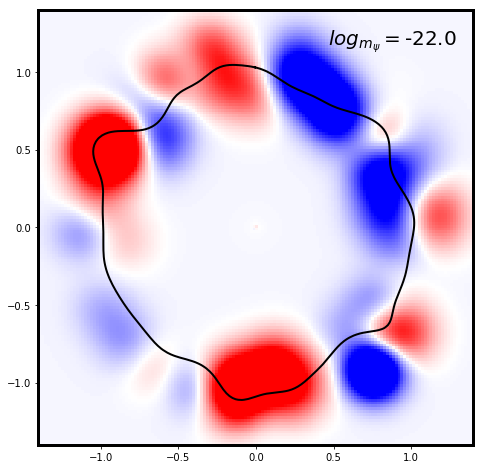

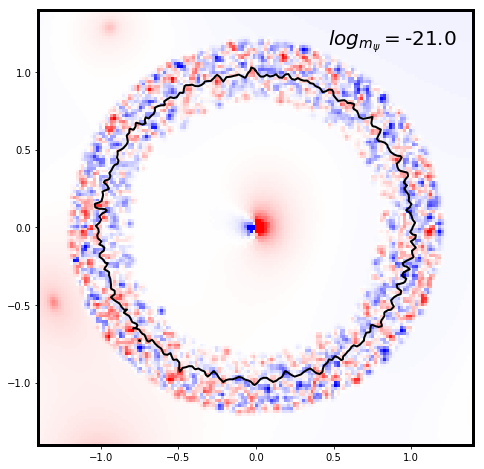

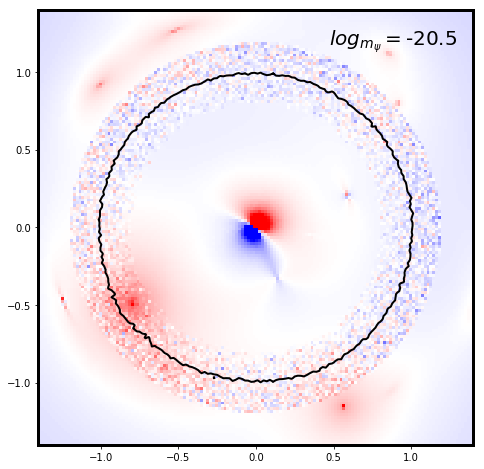

In [9]:
for i in range(len(log10_m_uldms)):

    lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationsULDM[i].lensing_quantities()

    astropy_instance = realizationsULDM[i].astropy_instance
    lens_model_halos_only = LensModel(lens_model_list, zlens, zsource, lens_redshift_array, 
                                      cosmo=astropy_instance, multi_plane=True)

    npix = 150 
    grid_size = 1.4
    _x = _y = np.linspace(-grid_size, grid_size, npix)
    xx, yy = np.meshgrid(_x, _y)
    shape0 = xx.shape

    # power law plus shear macromodel
    kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0., 'e2': 0.0, 'gamma': 2.},
                        {'gamma1': -0.01, 'gamma2': 0.001}]

    lens_model_list_macro = ['EPL', 'SHEAR']
    lens_model_list_full = lens_model_list_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos

    lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                                lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True, 
                                numerical_alpha_class=numerical_deflection_class)
    lens_model_macro = LensModel(lens_model_list_macro)

    kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
    kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

    lens_model_extension = LensModelExtensions(lens_model_full)
    grid_resolution = 0.02 # this can take a while for higher resolution computations of the critical curves
    ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                    compute_window=2*grid_size, 
                                                                    grid_scale=grid_resolution)
    
    fig = plt.figure(1)
    fig.set_size_inches(8,8)
    kappa_subs_nonlinear = kappa_full - kappa_macro

    # subtracting the mean can make halos appear more clearly 
    mean = np.mean(kappa_subs_nonlinear)
    plt.imshow(kappa_subs_nonlinear - mean, vmin=-0.05, vmax=0.05, cmap='bwr', extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

    for j in range(0, len(ra_crit_list)):
        plt.plot(ra_crit_list[j], dec_crit_list[j], color='k', lw=2)
    plt.suptitle(r'$log_{m_\psi}=$%s' % log10_m_uldms[i], fontsize=20, x=0.75, y=0.85)
    
    plt.show()

As the axion mass increases, more structure is introduced due to the decreasing minimum halo mass. For lighter axion masses, few to no halos form in the relevant mass range for strong lensing, $10^{[6,10]}\,M_\odot.$ In the limit that the axion mass tends to $\infty,$ we recover cold dark matter.

In [13]:
zlens, zsource = 0.4, 1.5
log10_m_uldms, uldm_plaw, scale_nfw = [-22.0,-21.], 1/3, False
flucs_args = {'aperture': 0.25, 'x_images': [1.0, 0.0, -1.0, 0.0], 'y_images': [0.0, 1.0, 0.0, -1.0]}
realizationsULDM = [ULDM(zlens, zsource, 
                       log10_m_uldm=log10_m_uldm, uldm_plaw=uldm_plaw,
                         flucs_shape='aperture',
                         flucs_args=flucs_args,
                         scale_nfw=scale_nfw, log10_fluc_amplitude=-1.5)
                   for log10_m_uldm in log10_m_uldms]

for i in range(len(log10_m_uldms)):
    print(r'ULDM realization with log(m)=%s contains %s halos' 
          % (log10_m_uldms[i], len(realizationsULDM[i].halos)))

ULDM realization with log(m)=-22.0 contains 28 halos
ULDM realization with log(m)=-21.0 contains 2280 halos


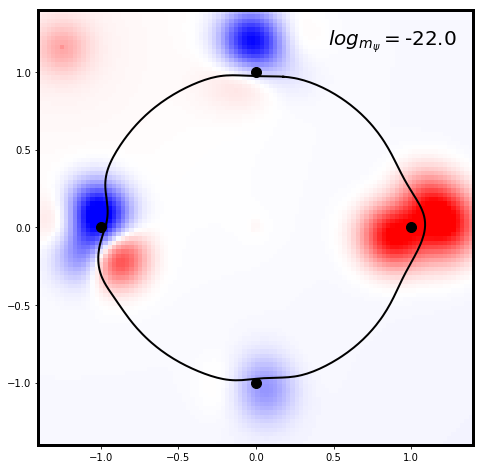

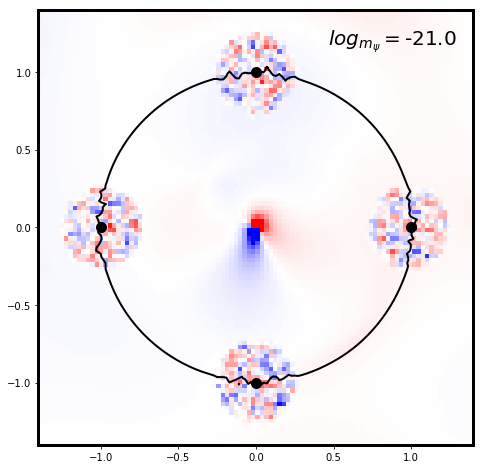

In [15]:
for i in range(len(log10_m_uldms)):

    lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationsULDM[i].lensing_quantities()

    astropy_instance = realizationsULDM[i].astropy_instance
    lens_model_halos_only = LensModel(lens_model_list, zlens, zsource, lens_redshift_array, 
                                      cosmo=astropy_instance, multi_plane=True)

    npix = 100 
    grid_size = 1.4
    _x = _y = np.linspace(-grid_size, grid_size, npix)
    xx, yy = np.meshgrid(_x, _y)
    shape0 = xx.shape

    # power law plus shear macromodel
    kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0., 'e2': 0.0, 'gamma': 2.},
                        {'gamma1': -0.01, 'gamma2': 0.001}]

    lens_model_list_macro = ['EPL', 'SHEAR']
    lens_model_list_full = lens_model_list_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos

    lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                                lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True, 
                                numerical_alpha_class=numerical_deflection_class)
    lens_model_macro = LensModel(lens_model_list_macro)

    kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
    kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

    lens_model_extension = LensModelExtensions(lens_model_full)
    grid_resolution = 0.02 # this can take a while for higher resolution computations of the critical curves
    ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                    compute_window=2*grid_size, 
                                                                    grid_scale=grid_resolution)
    
    
    fig = plt.figure(1)
    fig.set_size_inches(8,8)
    kappa_subs_nonlinear = kappa_full - kappa_macro

    # subtracting the mean can make halos appear more clearly 
    mean = np.mean(kappa_subs_nonlinear)
    plt.imshow(kappa_subs_nonlinear - mean, vmin=-0.05, vmax=0.05, cmap='bwr', extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')
    plt.scatter(flucs_args['x_images'], flucs_args['y_images'], s=100, color='k')
    
    for j in range(0, len(ra_crit_list)):
        plt.plot(ra_crit_list[j], dec_crit_list[j], color='k', lw=2)
    plt.suptitle(r'$log_{m_\psi}=$%s' % log10_m_uldms[i], fontsize=20, x=0.75, y=0.85)
    
    plt.show()

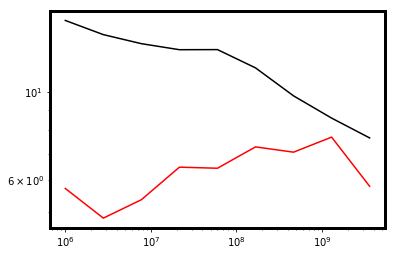

In [16]:
from pyHalo.preset_models import CDM

realizationsCDM = CDM(zlens, zsource, cone_opening_angle=10)
realizationsULDM = ULDM(zlens, zsource, 
                       log10_m_uldm=-20, uldm_plaw=uldm_plaw,
                        flucs=False, cone_opening_angle=10)

halo_masses = np.logspace(6, 10, 10)
mc_relation_uldm = []
mc_relation_cdm = []

halo_concentrations_uldm = np.array([halo.c for halo in realizationsULDM.halos])
halo_concentrations_cdm = np.array([halo.c for halo in realizationsCDM.halos])
uldm_halo_masses = np.array([halo.mass for halo in realizationsULDM.halos])
cdm_halo_masses = np.array([halo.mass for halo in realizationsCDM.halos])

for i in range(0, len(halo_masses)-1):
    
    condition = np.logical_and(uldm_halo_masses >= halo_masses[i], uldm_halo_masses<halo_masses[i+1])
    inds = np.where(condition)
    c = halo_concentrations_uldm[inds]
    mc_relation_uldm.append(np.median(c))
    
    condition = np.logical_and(cdm_halo_masses >= halo_masses[i], cdm_halo_masses<halo_masses[i+1])
    inds = np.where(condition)
    c = halo_concentrations_cdm[inds]
    mc_relation_cdm.append(np.median(c))

plt.loglog(halo_masses[0:-1], mc_relation_cdm, color='k')
plt.loglog(halo_masses[0:-1], mc_relation_uldm, color='r')